In [1]:
!pip install wurlitzer
%load_ext wurlitzer

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from numba import cuda
import numba
import math
import time

# 1 - lire l'image :

> Indented block



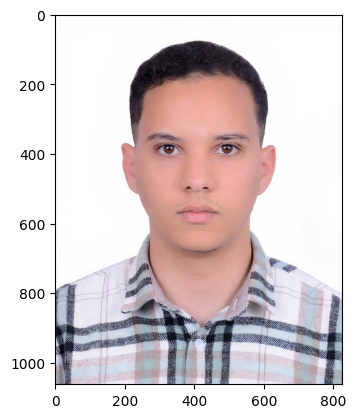

In [7]:
# Path to the image in your Google Drive
image_path = "./ap1.jpg"
# Open the image using Pillow
image = Image.open(image_path)

# Display the image
plt.imshow(image)


In [8]:
# Convert the Pillow image to a NumPy array
image_array = np.array(image)
image_array

array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[160, 155, 161],
        [168, 163, 169],
        [171, 166, 172],
        ...,
        [133, 140, 159],
        [143, 162, 194],
        [135, 154, 186]],

       [[158, 153, 159],
        [160, 155, 161],
        [170, 165, 171],
        ...,
        [104, 110, 132],
        [138, 138, 146],
        [151, 151, 159]],

       [[160, 155, 161],
        [164, 159, 165],
        [178, 173, 179],
        ...,
        [133, 137, 162],
        [140, 148, 167],
        [138, 146, 165]]

1 - MATRICE DE GAUSSIAN


In [9]:
gaussian = np.array([[1, 4, 6, 4, 1],
                         [4, 16, 24, 16, 4],
                         [6, 24, 36, 24, 6],
                         [4, 16, 24, 16, 4],
                         [1, 4, 6, 4, 1]])
# Increase the blur by scaling all values in the kernel
print(gaussian)

[[ 1  4  6  4  1]
 [ 4 16 24 16  4]
 [ 6 24 36 24  6]
 [ 4 16 24 16  4]
 [ 1  4  6  4  1]]


In [16]:
@cuda.jit
def process_image_cuda(image_array, gaussainGrid, result_array, directions):
    pos_i, pos_j = cuda.grid(2)
    tmpR = 0
    tmpG = 0
    tmpB = 0

    if pos_i < image_array.shape[0] and pos_j < image_array.shape[1]:
        R = image_array[pos_i, pos_j][0] # R
        G = image_array[pos_i, pos_j][1] # G
        B = image_array[pos_i, pos_j][2] # B

        for ni, nj in directions:
            new_i, new_j = pos_i + ni, pos_j + nj
            if 0 <= new_i and 0<=new_j and new_i < image_array.shape[0] and new_j < image_array.shape[1]:
                 tmpR += gaussainGrid[ni + 2, nj + 2] * image_array[new_i, new_j][0]
                 tmpG += gaussainGrid[ni + 2, nj + 2] * image_array[new_i, new_j][1]
                 tmpB += gaussainGrid[ni + 2, nj + 2] * image_array[new_i, new_j][2]
            else:
                  tmpR += gaussainGrid[ni + 2, nj + 2] * R
                  tmpG += gaussainGrid[ni + 2, nj + 2] * G
                  tmpB += gaussainGrid[ni + 2, nj + 2] * B

        result_array[pos_i, pos_j][0] = tmpR // 256
        result_array[pos_i, pos_j][1] = tmpG // 256
        result_array[pos_i, pos_j][2] = tmpB // 256


In [17]:
directions = [(0,0),
          (0, 1), (0, -1), (1, 0), (-1, 0),
          (1, 1), (-1, 1), (1, -1), (-1, -1),
          (0, 2), (0, -2), (2, 0), (-2, 0),
          (1, 2), (1, -2), (2, 1), (-2, 1),
          (-1, 2), (-1, -2), (2, -1), (-2, -1),
        ]
def process_image(image):
    result_image = np.zeros_like(image, dtype=np.float32)

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    d_input = cuda.to_device(image)
    d_output = cuda.to_device(result_image)
    d_gaussian = cuda.to_device(gaussian)
    d_directions = cuda.to_device(directions)

    process_image_cuda[blockspergrid, threadsperblock](d_input,d_gaussian, d_output, d_directions)

    d_output.copy_to_host(result_image)

    return result_image.astype(np.uint8)



array([[[249, 249, 249],
        [249, 249, 249],
        [249, 249, 249],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[249, 249, 249],
        [249, 249, 249],
        [249, 249, 249],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[249, 249, 249],
        [249, 249, 249],
        [249, 249, 249],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       ...,

       [[160, 155, 161],
        [164, 159, 165],
        [166, 161, 167],
        ...,
        [135, 143, 161],
        [135, 145, 165],
        [136, 149, 172]],

       [[158, 153, 159],
        [162, 157, 163],
        [165, 160, 166],
        ...,
        [128, 135, 154],
        [133, 139, 157],
        [141, 146, 160]],

       [[158, 153, 159],
        [162, 157, 163],
        [168, 163, 169],
        ...,
        [127, 133, 154],
        [133, 140, 158],
        [136, 143, 161]]

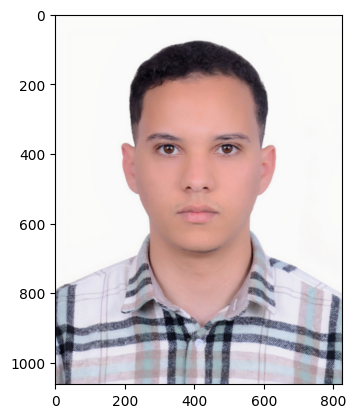

In [18]:
output_image = process_image(image_array)

# Display the image
plt.imshow(output_image)
output_image